## DroneMapper Crop Analysis
A jupyter notebook with crop analysis algorithms utilizing digital elevation models, dtm and multi-spectral imagery (R-G-B-NIR-Rededge-Thermal) from a [MicaSense Altum](https://micasense.com) sensor processed with [DroneMapper Remote Expert](https://dronemapper.com).

Test Data for this notebook: [https://dronemapper.com/software/DroneMapper_CropAnalysis_Data.zip](https://dronemapper.com/software/DroneMapper_CropAnalysis_Data.zip). Once that has been completed, extract the TIF files into the notebook data directory matching the structure below.

### Included Data
* data/DrnMppr-DEM-AOI.tif - 32bit georeferenced digital elevation model
* data/DrnMppr-ORT-AOI.tif - 16bit georeferenced orthomosaic (Red-Green-Blue-NIR-Rededge-Thermal)
* data/DrnMppr-DTM-AOI.tif - 32bit georeferenced dtm
* data/plant_count.shp - plant count AOI
* data/plots_1.shp - plot 1 AOI
* data/plots_2.shp - plot 2 AOI

### Algorithms
* plot volume/biomass
* plot canopy height
* plot ndvi zonal statistics
* plot thermals
* plant count

## Notes
These basic algorithms are intended to get you started and interested in multi-spectral processing and analysis.

The orthomosaic, digital elevation model, and dtm were clipped to an AOI using [GlobalMapper](https://bluemarblegeo.com). The shapefile plots were also generated using GlobalMapper grid tool. We highly recommend GlobalMapper for GIS work!

We cloned the MicaSense [imageprocessing](https://github.com/dronemapper-io/imageprocessing) repository and created the `Batch Processing DroneMapper.ipynb` notebook which allows you to quickly align and stack a Altum or RedEdge dataset creating the correct TIF files with EXIF/GPS metadata preserved. These stacked TIF files are then directly loaded into DroneMapper Remote Expert for processing.

This notebook assumes the user has basic knowledge of setting up their python environment, importing libraries and working inside jupyter.

## Do More!
Implement additional algorithms like NDRE or alternative methods for plant counts. Submit a pull request!

In [1]:
%load_ext autoreload
%autoreload 2

### Load Digital Elevation Model (DEM) and Orthomosaic

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


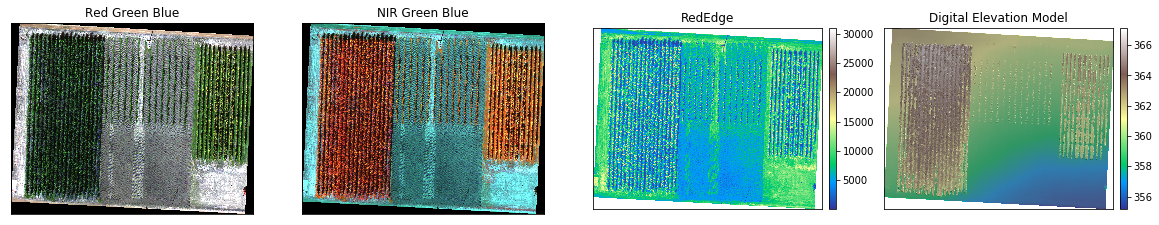

In [2]:
import numpy as np
import rasterio
from matplotlib import pyplot as plt
import matplotlib as mpl

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

# ensure libspatialindex-dev is installed via apt-get or yum

%matplotlib inline

dem = rasterio.open('data/DrnMppr-DEM-AOI.tif')
ortho = rasterio.open('data/DrnMppr-ORT-AOI.tif')

dem_arr = dem.read()
ortho_arr = ortho.read()

# mask elevation <= 0
elevation = dem_arr[0]
elevation[elevation <= 0] = np.nan

# rededge mask <= 0
masked_re = np.ma.masked_where(ortho_arr[4] <= 0, ortho_arr[4])

# generate hillshade
hillshade = es.hillshade(elevation, altitude=30, azimuth=210)

fig, ax = plt.subplots(1, 4, figsize=(20, 20))

# plot
ep.plot_rgb(ortho_arr, ax=ax[0], rgb=[0, 1, 2], title="Red Green Blue", stretch=True)
ep.plot_rgb(ortho_arr, ax=ax[1], rgb=[3, 1, 2], title="NIR Green Blue", stretch=True)
ep.plot_bands(masked_re, ax=ax[2], scale=False, cmap="terrain", title="RedEdge")
ep.plot_bands(elevation, ax=ax[3], scale=False, cmap="terrain", title="Digital Elevation Model")
ax[3].imshow(hillshade, cmap="Greys", alpha=0.5)
plt.show()


### Load Plot 1 AOI and Generate NDVI

### NDVI is a vegetation index that is associated with vegetation density. It is often used to distinguish vegetation from non-vegetation features. It normalizes the difference between the green leaf scattering in the near-infrared to the chlorophyll absorption. The NDVI is computed as follows:

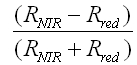

where RNIR is the reflectance in the near infrared part of the spectrum, and Rred is reflectance in the red part of the spectrum. The value of the index ranges from -1 to 1. 



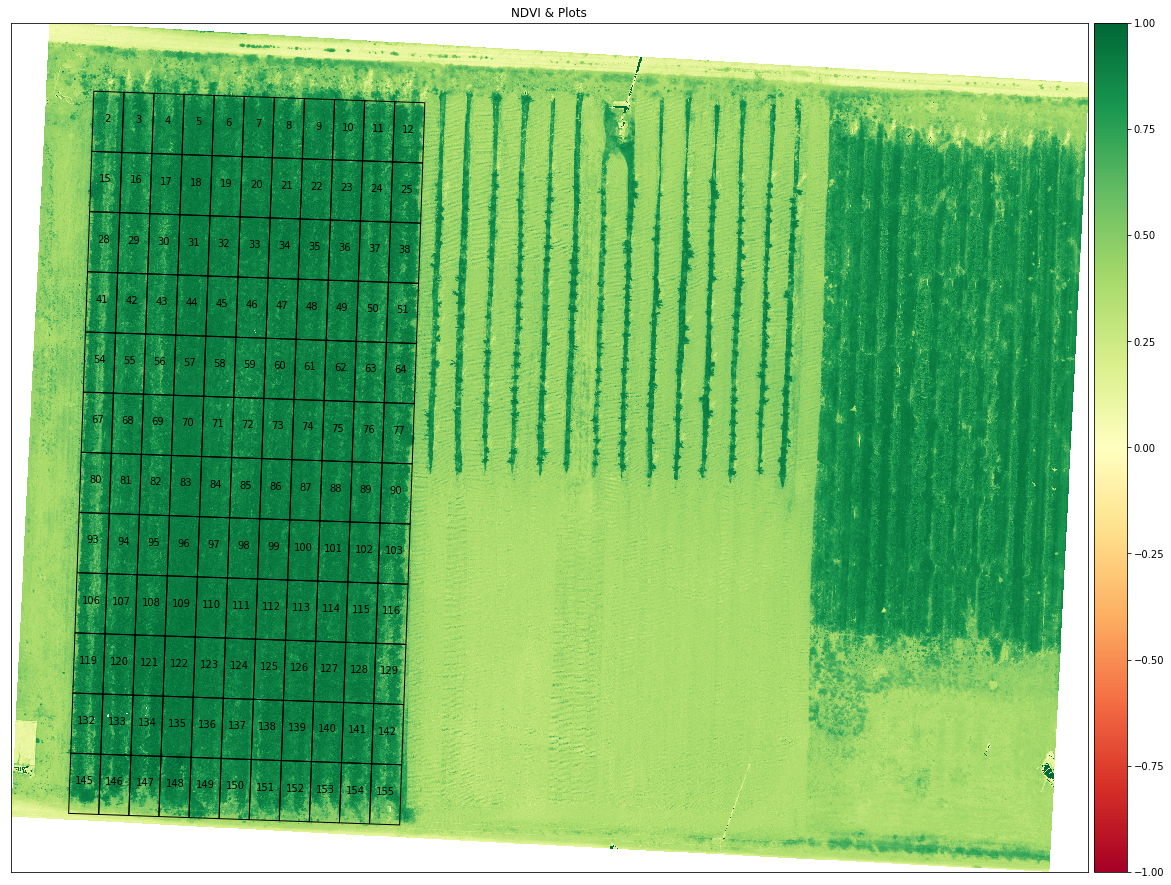

In [3]:
import geopandas as gpd
from rasterio.plot import plotting_extent

np.seterr(divide='ignore', invalid='ignore')

fig, ax = plt.subplots(figsize=(20, 20))
plot_extent = plotting_extent(dem_arr[0], dem.transform)

# generate ndvi
ndvi = es.normalized_diff(ortho_arr[3], ortho_arr[0])
ep.plot_bands(ndvi, 
              ax=ax, 
              cmap="RdYlGn",
              title="NDVI & Plots", 
              scale=False, 
              vmin=-1, 
              vmax=1, 
              extent=plot_extent)

plots = gpd.read_file('data/plots_1.shp')
plots.plot(ax=ax,
           color='None', 
           edgecolor='black', 
           linewidth=1)

# show plot names
plots.apply(lambda x: ax.annotate(s=x.NAME, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
plt.show()

### Generate NDVI Zonal Statistics For Each Plot

#### A common range for green vegetation is 0.2 to 0.8. 

LAYER               MAP_NAME NAME  count  \
0  Coverage/Quad  User Created Features    2   4444   
1  Coverage/Quad  User Created Features    3   4440   
2  Coverage/Quad  User Created Features    4   4440   
3  Coverage/Quad  User Created Features    5   4444   
4  Coverage/Quad  User Created Features    6   4442   

                                            geometry       max      mean  \
0  POLYGON Z ((289583.708 5130289.226 0.000, 2895...  0.873092  0.438559   
1  POLYGON Z ((289588.705 5130289.052 0.000, 2895...  0.887971  0.445282   
2  POLYGON Z ((289593.702 5130288.877 0.000, 2895...  0.890147  0.552864   
3  POLYGON Z ((289598.699 5130288.703 0.000, 2896...  0.865083  0.530295   
4  POLYGON Z ((289603.696 5130288.528 0.000, 2896...  0.922450  0.536660   

     median       min       std  
0  0.436500  0.188461  0.078921  
1  0.425304  0.193214  0.091090  
2  0.519746  0.232222  0.112440  
3  0.515392  0.090825  0.110570  
4  0.495813  0.104697  0.132731

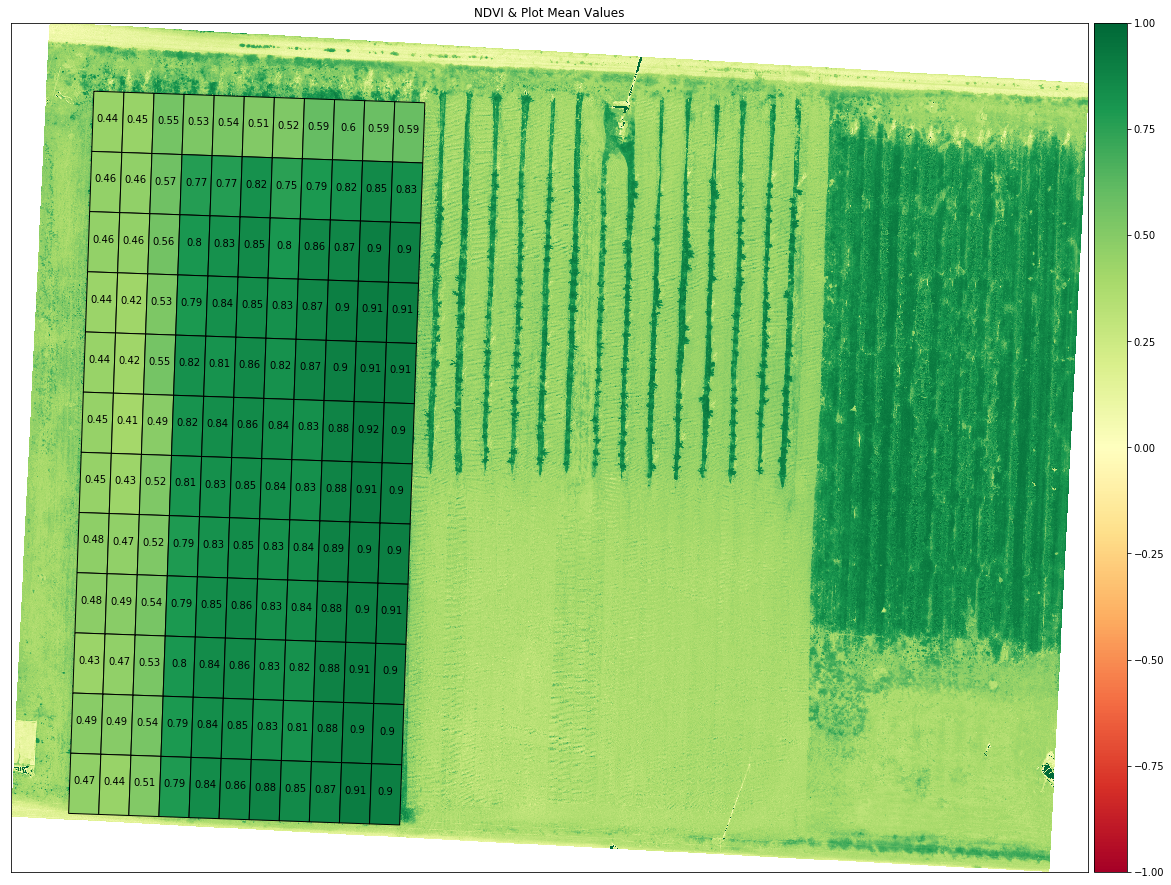

In [4]:
import rasterstats as rs
from shapely.geometry import Polygon
from IPython.display import display

# compute zonal statistics on each plot
plot_zs = rs.zonal_stats(plots, 
                         ndvi, 
                         nodata=0, 
                         affine=dem.transform, 
                         geojson_out=True, 
                         copy_properties=True, 
                         stats="count min mean max median std")

# build dataframe and display first 5 records
plot_df = gpd.GeoDataFrame.from_features(plot_zs)
display(plot_df.head())
plot_df.to_csv('output/aoi1_plot_mean_ndvi.csv')

fig, ax = plt.subplots(figsize=(20, 20))

# plot ndvi
ep.plot_bands(ndvi, 
              ax=ax, 
              cmap="RdYlGn",
              title="NDVI & Plot Mean Values", 
              scale=False, 
              vmin=-1, 
              vmax=1, 
              extent=plot_extent)

# overlay the mean ndvi value color for each plot and all pixels inside plot
plot_df.plot('mean',
             ax=ax, 
             cmap='RdYlGn', 
             edgecolor='black', 
             linewidth=1,
             vmin=-1,
             vmax=1)

# show plot mean values
plot_df.apply(lambda x: ax.annotate(s='{:.2}'.format(x['mean']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
plt.show()

You can view the Plot 1 AOI mean plot NDVI values: [aoi1_plot_mean_ndvi.csv](output/aoi1_plot_mean_ndvi.csv)
### Load Plot 2 AOI & Compute DEM Canopy Mean Height For Each Plot

LAYER                               MAP_NAME NAME  count  \
0  Coverage/Quad  User Created Features - Coverage/Quad    1   3318   
1  Coverage/Quad  User Created Features - Coverage/Quad    2   3316   
2  Coverage/Quad  User Created Features - Coverage/Quad    3   3310   
3  Coverage/Quad  User Created Features - Coverage/Quad    4   3322   
4  Coverage/Quad  User Created Features - Coverage/Quad    5   3320   

                                            geometry         max        mean  \
0  POLYGON Z ((289707.875 5130279.812 1182.502, 2...  363.381683  361.141294   
1  POLYGON Z ((289712.189 5130279.586 1190.569, 2...  363.382446  361.710297   
2  POLYGON Z ((289716.503 5130279.360 1183.212, 2...  363.384766  361.138592   
3  POLYGON Z ((289720.817 5130279.134 1182.668, 2...  363.387207  361.915436   
4  POLYGON Z ((289725.131 5130278.908 1182.782, 2...  363.377991  361.558501   

       median         min       std  
0  360.441467  360.129120  1.091593  
1  361.927017  360.131866  1.215926  
2  360.425781  360.117279  1.122890  
3  362.585251  360.110443  1.258644  
4  360.546524  360.006683  1.305164

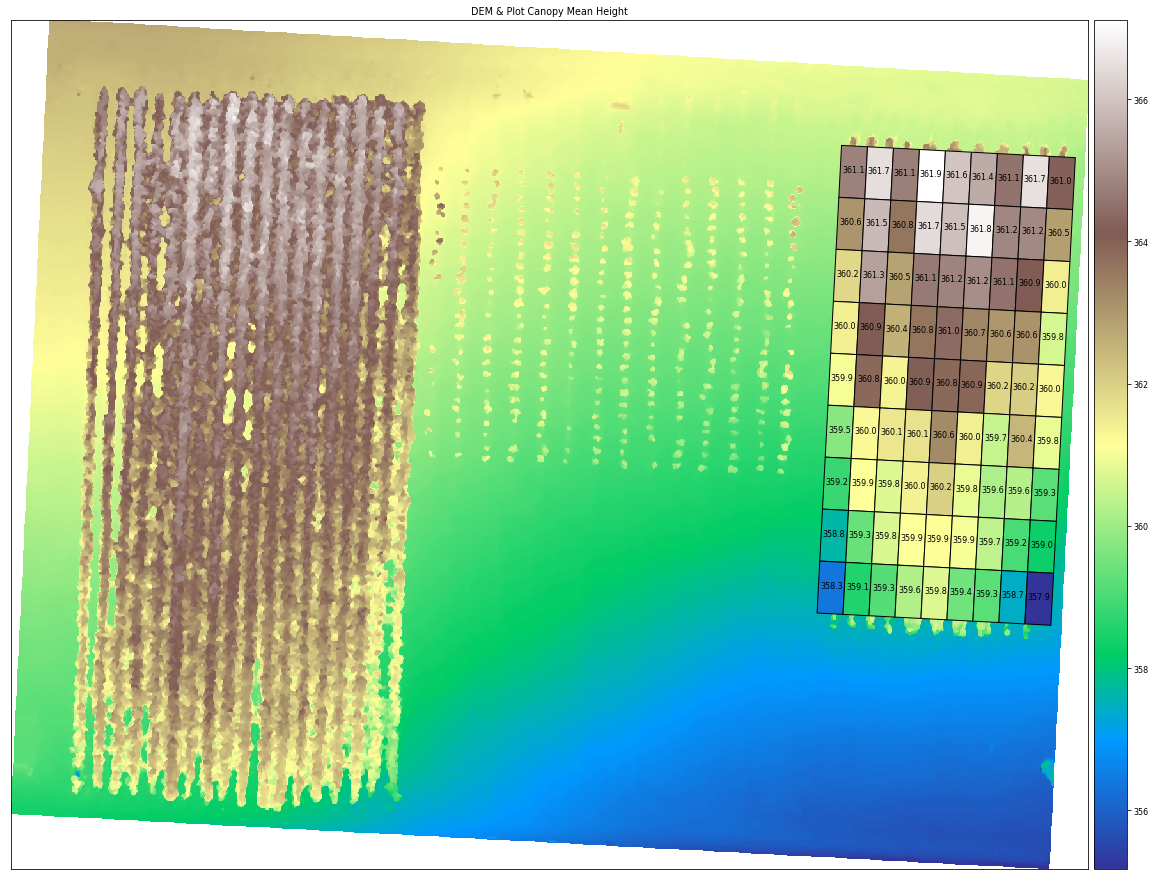

In [5]:
plots = gpd.read_file('data/plots_2.shp')
plt.rcParams.update({'font.size': 8})

# compute zonal statistics on each plot
plot_zs = rs.zonal_stats(plots, 
                         elevation, 
                         nodata=0, 
                         affine=dem.transform, 
                         geojson_out=True, 
                         copy_properties=True, 
                         stats="count min mean max median std")

# build dataframe and display first 5 records
plot_df = gpd.GeoDataFrame.from_features(plot_zs)
display(plot_df.head())
plot_df.to_csv('output/aoi2_plot_mean_height.csv')

fig, ax = plt.subplots(figsize=(20, 20))

# plot dem
ep.plot_bands(elevation, 
              ax=ax, 
              cmap="terrain",
              title="DEM & Plot Canopy Mean Height", 
              scale=False, 
              extent=plot_extent)

# overlay the mean dem value color for each plot and all pixels inside plot
plot_df.plot('mean',
             ax=ax, 
             cmap='terrain', 
             edgecolor='black', 
             linewidth=1)

# show plot mean values
plot_df.apply(lambda x: ax.annotate(s='{0:0.1f}'.format(x['mean']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
plt.show()

You can view the Plot 2 AOI mean plot height values: [aoi2_plot_mean_height.csv](output/aoi2_plot_mean_height.csv)
### Compute Thermal Mean For Each Plot
The thermal band (5) in the processed orthomosaic shows stitching artifacts which could likely be improved using more accurate pre-processing alignment and de-distortion algorithms. You can find more information about these functions in the MicaSense imageprocessing github repository. See notes at the top of this notebook.

LAYER                               MAP_NAME NAME  count  \
0  Coverage/Quad  User Created Features - Coverage/Quad    1   3318   
1  Coverage/Quad  User Created Features - Coverage/Quad    2   3316   
2  Coverage/Quad  User Created Features - Coverage/Quad    3   3310   
3  Coverage/Quad  User Created Features - Coverage/Quad    4   3322   
4  Coverage/Quad  User Created Features - Coverage/Quad    5   3320   

                                            geometry      max          mean  \
0  POLYGON Z ((289707.875 5130279.812 1182.502, 2...  30431.0  30196.628692   
1  POLYGON Z ((289712.189 5130279.586 1190.569, 2...  30560.0  30333.192702   
2  POLYGON Z ((289716.503 5130279.360 1183.212, 2...  30645.0  30266.030211   
3  POLYGON Z ((289720.817 5130279.134 1182.668, 2...  30700.0  30386.137267   
4  POLYGON Z ((289725.131 5130278.908 1182.782, 2...  30691.0  30209.904518   

    median      min         std  
0  30193.0  30008.0  120.982058  
1  30332.0  30068.0  123.856093  
2  30275.5  29792.0  170.831207  
3  30391.0  29790.0  201.266919  
4  30262.0  29618.0  292.299392

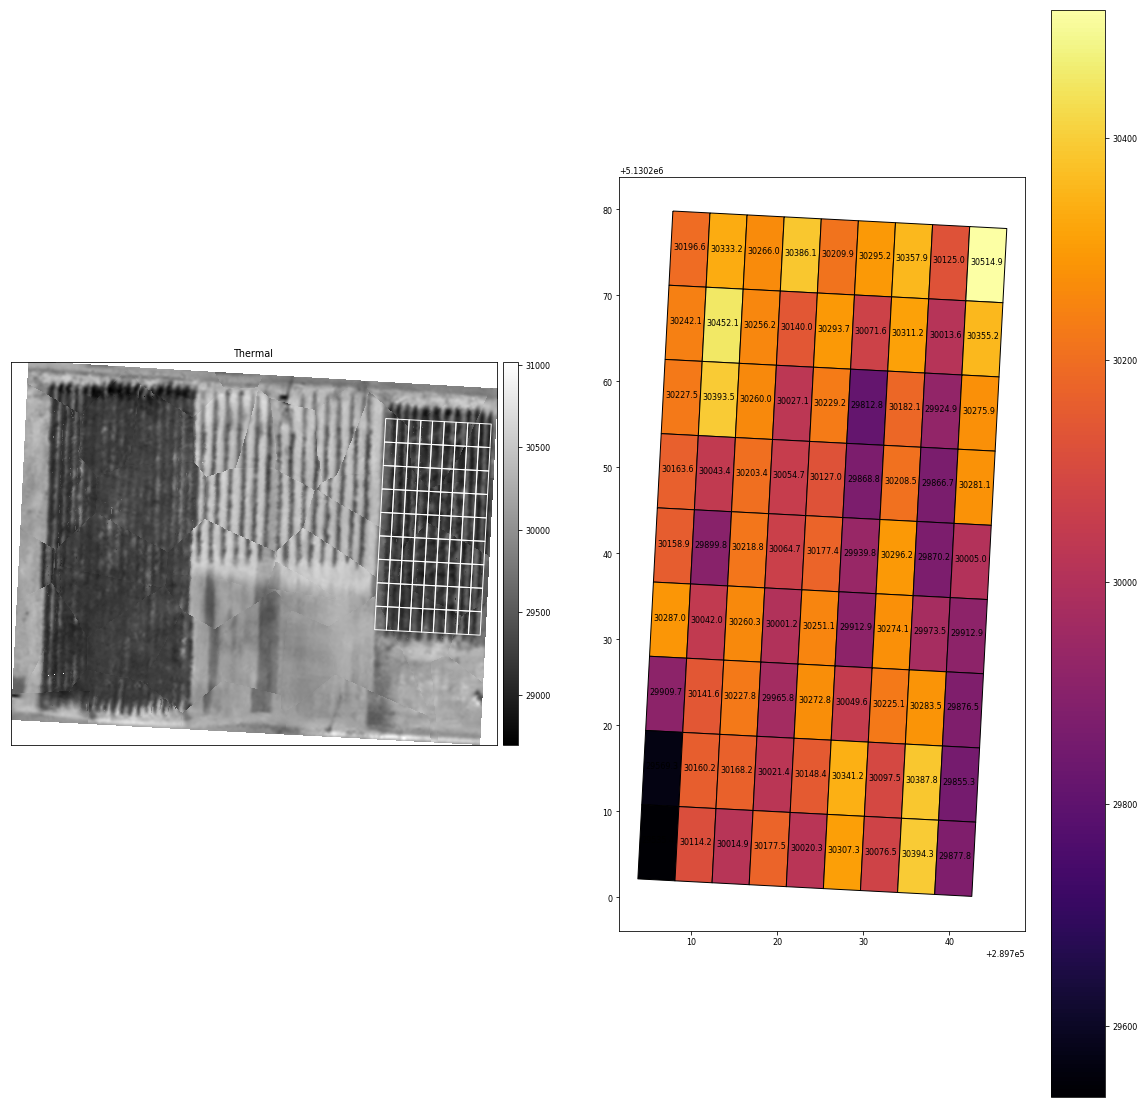

In [6]:
# thermal mask <= 0
masked_thermal = np.ma.masked_where(ortho_arr[5] <= 0, ortho_arr[5])

# compute zonal statistics on each plot
plot_zs = rs.zonal_stats(plots, 
                         masked_thermal, 
                         nodata=0, 
                         affine=dem.transform, 
                         geojson_out=True, 
                         copy_properties=True, 
                         stats="count min mean max median std")

# build dataframe and display first 5 records
plot_df = gpd.GeoDataFrame.from_features(plot_zs)
display(plot_df.head())
plot_df.to_csv('output/aoi2_plot_mean_thermal.csv')

fig, ax = plt.subplots(1, 2, figsize=(20, 20))

# plot thermal
ep.plot_bands(masked_thermal,
              ax=ax[0], 
              scale=False, 
              cmap="gist_gray", 
              title="Thermal",
              extent=plot_extent)

plots.plot(ax=ax[0], color='None', edgecolor='white', linewidth=1)

# display thermal plot
plot_df.plot('mean',
             ax=ax[1], 
             cmap='inferno', 
             edgecolor='black',
             linewidth=1,
             legend=True)


# show plot mean values
plot_df.apply(lambda x: ax[1].annotate(s='{0:0.1f}'.format(x['mean']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
plt.show()

You can view the Plot 2 AOI mean plot thermal values: [aoi2_plot_mean_thermal.csv](output/aoi2_plot_mean_thermal.csv)
### Load Plot 1 AOI & Compute Volume/Biomass For Each Plot

LAYER               MAP_NAME NAME  count  \
0  Coverage/Quad  User Created Features    2   4444   
1  Coverage/Quad  User Created Features    3   4440   
2  Coverage/Quad  User Created Features    4   4440   
3  Coverage/Quad  User Created Features    5   4444   
4  Coverage/Quad  User Created Features    6   4442   

                                            geometry       max      mean  \
0  POLYGON Z ((289583.708 5130289.226 0.000, 2895...  3.525543  1.532524   
1  POLYGON Z ((289588.705 5130289.052 0.000, 2895...  3.575226  1.646664   
2  POLYGON Z ((289593.702 5130288.877 0.000, 2895...  3.992493  1.884596   
3  POLYGON Z ((289598.699 5130288.703 0.000, 2896...  4.575989  2.969443   
4  POLYGON Z ((289603.696 5130288.528 0.000, 2896...  5.105408  3.155879   

        min           sum   volume_m3  area_m2  
0 -0.153473   6810.538483   76.650368     50.0  
1 -0.094482   7311.188690   82.285021     50.0  
2 -0.070648   8367.608276   94.174676     50.0  
3  0.032928  13196.202637  148.518915     50.0  
4  0.074188  14018.412506  157.772617     50.0

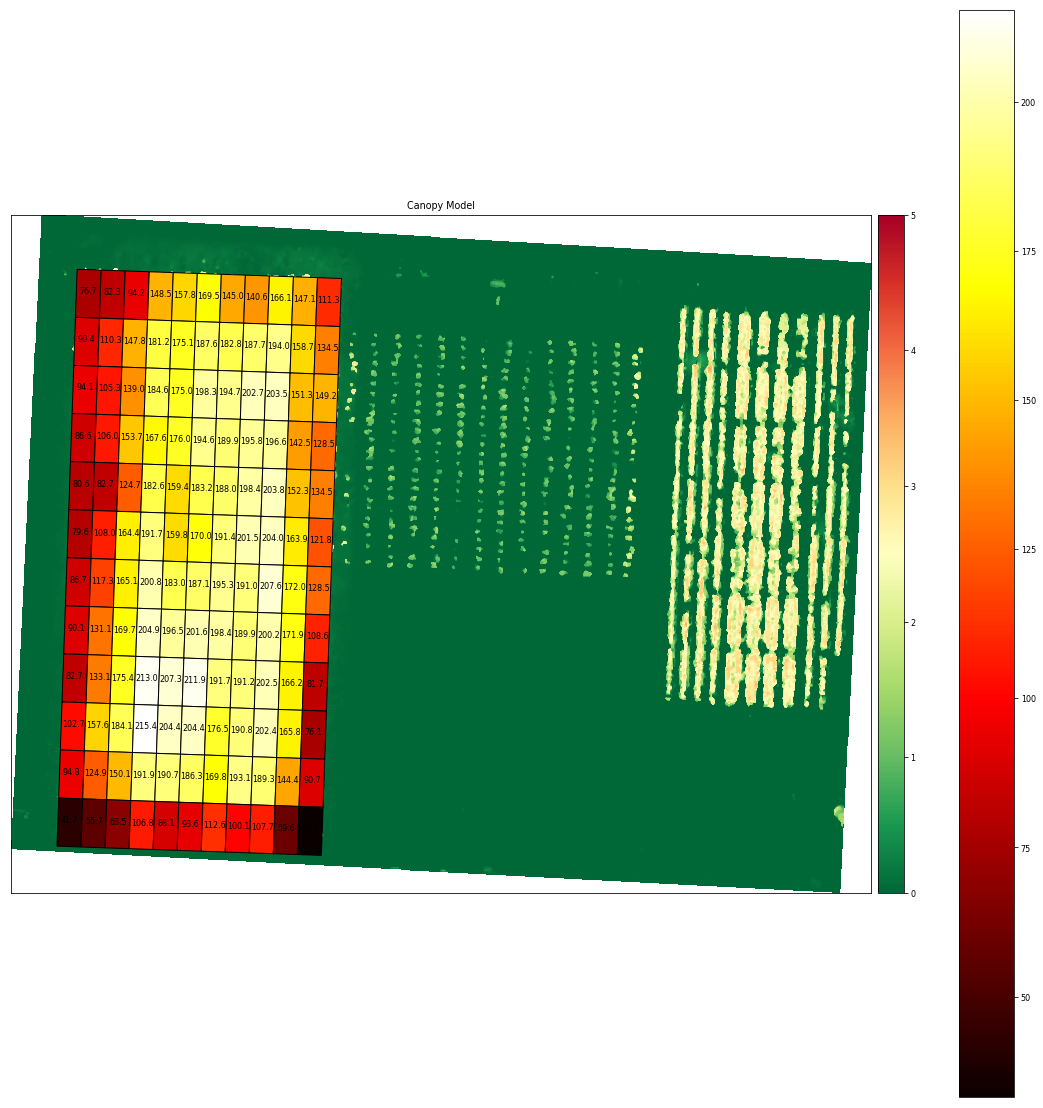

In [7]:
# we will use the masked dtm and masked elevation data
plots = gpd.read_file('data/plots_1.shp')

dtm = rasterio.open('data/DrnMppr-DTM-AOI.tif')
dtm_arr = dtm.read()

# mask dtm <= 0
elevation_dtm = dtm_arr[0]
elevation_dtm[elevation_dtm <= 0] = np.nan

# create canopy model
canopy_model = (elevation - elevation_dtm)

# compute zonal statistics on each plot
plot_zs = rs.zonal_stats(plots, 
                         canopy_model, 
                         nodata=0, 
                         affine=dem.transform, 
                         geojson_out=True, 
                         copy_properties=True, 
                         stats="sum count min mean max")

# get pixel size
transform = dtm.transform
pixel_size_x = transform[0]
pixel_size_y = -transform[4]

# calculate volume
def volume(pixel_count, pixel_sum):
    return (pixel_sum / pixel_count * (pixel_size_x * pixel_size_y) * pixel_count)

# build dataframe and display first 5 records
plot_df = gpd.GeoDataFrame.from_features(plot_zs)

# add columns to dataframe
plot_df['volume_m3'] = plot_df.apply(lambda x: volume(x['count'], x['sum']), axis=1)
plot_df['area_m2'] = plot_df.apply(lambda x: x.geometry.area, axis=1)

display(plot_df.head())
plot_df.to_csv('output/aoi1_plot_volume.csv')

fig, ax = plt.subplots(figsize=(20, 20))

# plot canopy model
ep.plot_bands(canopy_model, 
              ax=ax, 
              scale=False, 
              cmap="RdYlGn_r", 
              title="Canopy Model", 
              extent=plot_extent,
              vmin=0,
              vmax=5)

# display volume plot
plot_df.plot('volume_m3',
             ax=ax, 
             cmap='hot', 
             edgecolor='black',
             linewidth=1,
             legend=True)

# show plot names
plot_df.apply(lambda x: ax.annotate(s='{0:0.1f}'.format(x['volume_m3']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
plt.show()

You can view the Plot 1 AOI plot volume/biomass values: [aoi1_plot_volume.csv](output/aoi1_plot_volume.csv)
### Load Plant Count AOI & Count Plants

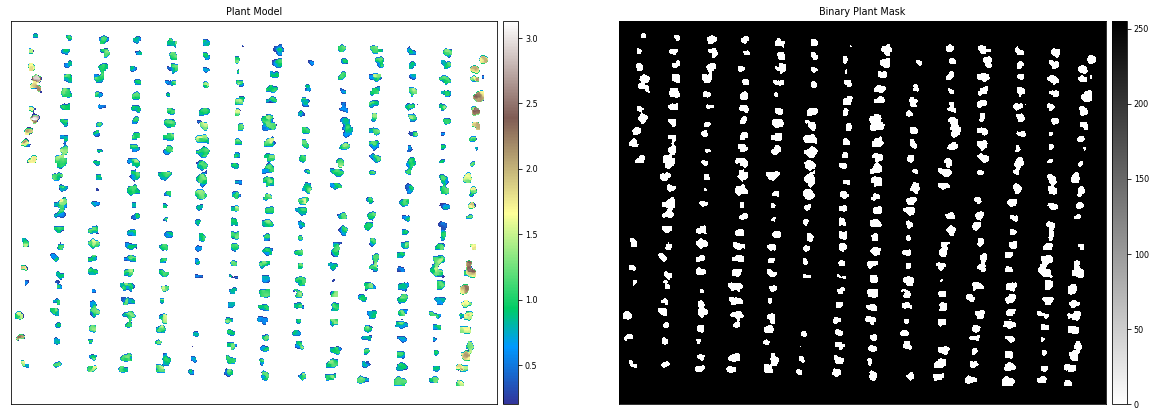

Plant count: 310


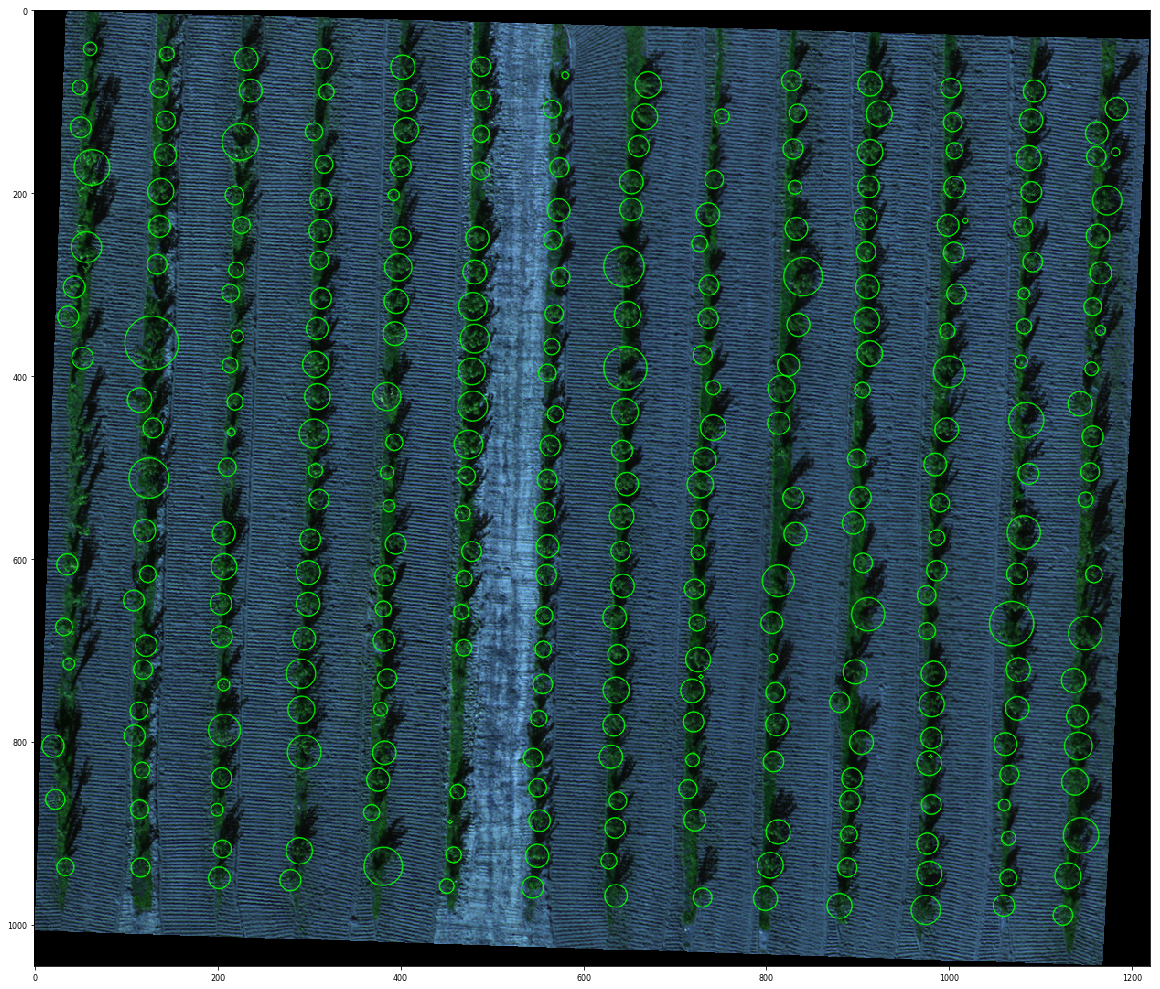

UTMX           UTMY
0 289622.411171 5130240.899705
1 289621.849705 5130244.325966
2 289622.101569 5130248.858655
3 289621.865031 5130253.863371
4 289621.436280 5130258.158493

In [8]:
import pandas as pd
import cv2

# we will use the masked dtm and masked elevation data
plot = gpd.read_file('data/plant_count.shp')

# mask the dtm and dem to the plot extent
dtm_clip, dtm_transform = rasterio.mask.mask(dtm, plot.geometry, crop=True)
dem_clip, dem_transform = rasterio.mask.mask(dem, plot.geometry, crop=True)
rgb_clip, ort_transform = rasterio.mask.mask(ortho, plot.geometry, crop=True)

# filter elevations <= 0
dtm_clip[dtm_clip <= 0] = np.nan
dem_clip[dem_clip <= 0] = np.nan

# filter plant model ground pixels
plant_model = (dem_clip - dtm_clip)
plant_model[plant_model <= 0.20] = np.nan

# generate binary image
binary_image = 255 * (plant_model[0] > 0)
binary_image_int = cv2.bitwise_not(binary_image.astype(np.uint8))

fig, ax = plt.subplots(1, 2, figsize=(20, 20))

# plot plant model
ep.plot_bands(plant_model[0], 
              ax=ax[0], 
              scale=False, 
              cmap="terrain", 
              title="Plant Model", 
              extent=plot_extent)

# plot binary image
ep.plot_bands(binary_image_int, 
              ax=ax[1], 
              scale=False, 
              cmap="binary", 
              title="Binary Plant Mask", 
              extent=plot_extent)
plt.show()

fig, ax = plt.subplots(figsize=(20,20))

# setup basic blob detector
params = cv2.SimpleBlobDetector_Params()
params.minDistBetweenBlobs = 1
params.filterByColor = False
params.blobColor = 255
params.filterByArea = True
params.minArea = 5; 
params.maxArea = 5000; 
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.maxInertiaRatio = 1
detector = cv2.SimpleBlobDetector_create(params)

# build new rgb image
rgb = np.stack((rgb_clip[0], rgb_clip[1], rgb_clip[2]), -1)
rgb = es.bytescale(rgb, high=255, low=0)

# resize binary_image_int to match rgb
binary_image_int = cv2.resize(binary_image_int, dsize=(rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_CUBIC)

# detect
keypoints = detector.detect(binary_image_int)

print('Plant count: {}'.format(len(keypoints)))

# plot plant count
plants = cv2.drawKeypoints(rgb, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(plants)
plt.show()

# show full values in dataframe display
pd.set_option('display.float_format', lambda x: '%.6f' % x)
plant_coordinates = {}

# extract plant geo positions
for i, keypoint in enumerate(keypoints):
    plant_center = ortho.xy(keypoint.pt[0], keypoint.pt[1])
    plant_coordinates[i] = [plant_center[0], plant_center[1]]
    
plant_df = pd.DataFrame.from_dict(plant_coordinates, orient='index', columns=['UTMX', 'UTMY'])
display(plant_df.head())
plant_df.to_csv('output/plant_count.csv')

You can view the plant counts: [plant_count.csv](output/plant_count.csv)